In [2]:
import tomopy
import matplotlib.pyplot as plt
import numpy as np
import k3d
# impoer resize 3D image
from skimage.transform import resize
import tifffile as tiff
import glob
import tqdm

k3d.switch_to_text_protocol()
def normalize_01(images):
    return (images - images.min()) / (images.max() - images.min())

In [21]:
# read tif file
import tifffile as tiff
import glob
import tqdm
import os
import cv2
os.makedirs("/home/nhattm/ToMoDL/datasets/ctf_cut_10x", exist_ok=True)
resize_factor = 20
file_names = sorted(glob.glob("/home/nhattm/ToMoDL/datasets/ctf/*.tif"))
sinos = []
for file_name in tqdm.tqdm(file_names[::10]):
    sino = tiff.imread(file_name)
    sino = np.asarray(sino)
    sino = sino.astype(np.float32)
    # sino = sino[:1700, :]
    # sino = cv2.resize(sino, (sino.shape[1]//resize_factor, sino.shape[0]//resize_factor))
    sino = resize(sino, (sino.shape[0]//resize_factor, sino.shape[1]//resize_factor), anti_aliasing=True)
    tiff.imwrite(f"/home/nhattm/ToMoDL/datasets/ctf_cut_10x/{file_name.split('/')[-1]}", sino)
    sinos.append(sino)

sinos = np.stack(sinos)

100%|██████████| 180/180 [00:30<00:00,  5.85it/s]


In [4]:
resize_factor = 20
file_names = sorted(glob.glob("/home/nhattm/ToMoDL/datasets/ctf/*.tif"))
sinos = []
for file_name in tqdm.tqdm(file_names):
    sino = tiff.imread(file_name)
    sino = np.asarray(sino)
    # sino = sino[:, 50:-50]
    # sino = normalize_01(sino)
    sino = resize(sino, (sino.shape[0]//resize_factor, sino.shape[1]//resize_factor), anti_aliasing=True)
    sinos.append(sino)

sinos = np.stack(sinos)
# sinos = normalize_01(sinos)

100%|██████████| 1800/1800 [05:10<00:00,  5.79it/s]


In [19]:
# resize_factor = 2
# file_names = sorted(glob.glob("/home/nhattm/ToMoDL/datasets/student_data/*"))
# sinos = []
# for file_name in tqdm.tqdm(file_names):
#     # read jpg file
#     sino = plt.imread(file_name)
#     sino = np.asarray(sino)
#     # sino = sino[:, 50:-50]
#     # sino = normalize_01(sino)
#     # sino = resize(sino, (sino.shape[0] // resize_factor, sino.shape[1] // resize_factor), anti_aliasing=True)
#     sinos.append(sino)

# sinos = np.stack(sinos)

100%|██████████| 100/100 [00:00<00:00, 2781.79it/s]


In [9]:
sinos.min(), sinos.max(), sinos.shape

(-5.6836324, 0.9683472, (1800, 102, 102))

In [6]:
height, width = sinos.shape[1], sinos.shape[2]
img = sinos[0]
corner_size = int(min(height, width) * 0.03)

# Extract the four corner regions (top-left, top-right, bottom-left, bottom-right)
top_left = img[:corner_size, :corner_size]
top_right = img[:corner_size, -corner_size:]
bottom_left = img[-corner_size:, :corner_size]
bottom_right = img[-corner_size:, -corner_size:]
middle_left = img[height//2-corner_size//2:height//2+corner_size//2, :corner_size]
middle_right = img[height//2-corner_size//2:height//2+corner_size//2, -corner_size:]
corner_means = np.array([top_left.mean(), top_right.mean(), bottom_left.mean(), bottom_right.mean(), middle_left.mean(), middle_right.mean()])
valid_corners = corner_means[(corner_means > np.percentile(corner_means, 10)) & (corner_means < np.percentile(corner_means, 90))]
flat_field_estimate = valid_corners.mean()


sinos_normalized = sinos / flat_field_estimate
# sinos_normalized = normalize_01(sinos_normalized)
# sinos_normalized = -np.log10(sinos_normalized +1e-4)
sinos_normalized = normalize_01(sinos_normalized)

In [10]:
flat_field_estimate

-0.21110722

In [5]:
sino2 = sinos / flat_field_estimate
sino2 = normalize_01(sino2)

In [11]:
sinos_normalized.min(), sinos_normalized.max()

(0.0, 1.0)

In [22]:
corner_size = int(min(height, width) * 0.03)

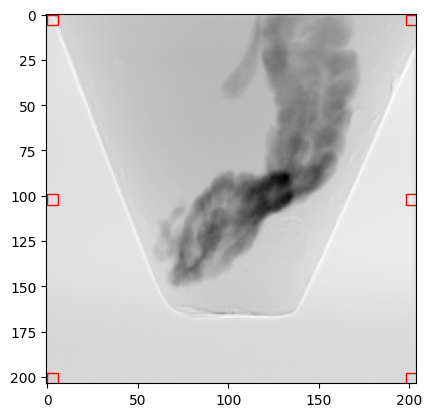

In [12]:
import matplotlib.patches as patches

# Display the first sinogram
fig, ax = plt.subplots(1)
ax.imshow(sinos[0], cmap="gray")

# Draw rectangles around the corners
rect_top_left = patches.Rectangle((0, 0), corner_size, corner_size, linewidth=1, edgecolor='r', facecolor='none')
rect_top_right = patches.Rectangle((width - corner_size, 0), corner_size, corner_size, linewidth=1, edgecolor='r', facecolor='none')
rect_bottom_left = patches.Rectangle((0, height - corner_size), corner_size, corner_size, linewidth=1, edgecolor='r', facecolor='none')
rect_bottom_right = patches.Rectangle((width - corner_size, height - corner_size), corner_size, corner_size, linewidth=1, edgecolor='r', facecolor='none')
rect_middle_left = patches.Rectangle((0, height//2 - corner_size//2), corner_size, corner_size, linewidth=1, edgecolor='r', facecolor='none')
rect_middle_right = patches.Rectangle((width - corner_size, height//2 - corner_size//2), corner_size, corner_size, linewidth=1, edgecolor='r', facecolor='none')
# Add the rectangles to the plot
ax.add_patch(rect_top_left)
ax.add_patch(rect_top_right)
ax.add_patch(rect_bottom_left)
ax.add_patch(rect_bottom_right)
ax.add_patch(rect_middle_left)
ax.add_patch(rect_middle_right)

plt.show()


In [7]:
plt.imshow(sino2[0], cmap="gray")

NameError: name 'sino2' is not defined

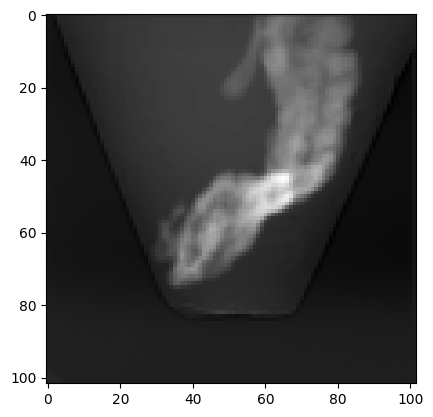

In [11]:
plt.imshow(sinos_normalized[0], cmap="gray")

In [17]:
sinos_normalized.shape

(1800, 102, 102)

In [19]:
theta = tomopy.angles(sinos_normalized.shape[0])
rec = tomopy.recon(sinos_normalized, theta, algorithm="gridrec", filter_name="ramlak")
rec = tomopy.circ_mask(rec, axis=0, ratio=0.95)
# rec = rec.max() - rec
rec = (rec - rec.min()) / (rec.max() - rec.min())
rec = rec * (2**16 - 1)
rec = rec.astype(np.uint16)
tiff.imwrite("/home/nhattm/tomopy_20x_gridrec.tif", rec)

In [17]:
rec.min(), rec.max()

(0, 65535)

In [168]:
# normalize the reconstruction from 0 to 255


# save the reconstruction

In [20]:
import napari
from dask_image.imread import imread

# stack = imread("/home/nhattm/opt_volume_filter.tif")
napari.view_image(rec)

Viewer(camera=Camera(center=(0.0, 50.5, 50.5), zoom=4.612094900330195, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(50.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 102.0, 1.0), (0.0, 102.0, 1.0), (0.0, 102.0, 1.0)), current_step=(50, 50, 50), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'rec' at 0x74c977310550>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x74c94c8a6dd0>], _persisted_mouse_event={}, _mouse_drag_gen={}, _mouse_wheel_gen={}, keymap={})

In [10]:
#save the reconstruction


In [ ]:
rec.shape

In [ ]:
#plot the reconstruction 3Dvolume with matplotlib
plt.show(rec)

In [ ]:
# import tifffile as tiff
# import glob
# import tqdm
# from natsort import natsorted
# from PIL import Image
# file_names = natsorted(glob.glob("/home/nhattm/ToMoDL/datasets/student_data/*.jpg"))
# sinos = []
# for file_name in tqdm.tqdm(file_names):
#     sino = Image.open(file_name)
#     sino = np.asarray(sino)
#     sino = sino.astype(np.float32)
#     sinos.append(sino)

# sinos = np.stack(sinos)

In [136]:
# sinos = tomopy.minus_log(sinos)


In [ ]:
plt.imshow(sinos[:,100, :], cmap="gray")
plt.show()

In [ ]:
extra_options = {'MinConstraint': 0}
options = {
    # 'proj_type': 'cuda',
    # "filter_name": "ramlak",

    # 'num_iter': 200,
    # 'extra_options': extra_options,
    # "accelerated": True
}
# rec = tomopy.recon(sinos,theta, algorithm="gridrec",filter_name= "ramlak")
batch_size = 1
batch_start = 0
batch_end = batch_start + batch_size
recs = []
while batch_end <= sinos.shape[0]:
    rec = tomopy.recon(sinos[batch_start:batch_end],theta[batch_start:batch_end], algorithm="gridrec",filter_name= "ramlak")
    recs.append(rec)
    batch_end = batch_start + batch_size
    batch_start = batch_end
    
recs = np.stack(recs)

In [ ]:
#save the reconstruction
tiff.imwrite("reconstruction.tif", rec)


In [ ]:
# build a widget to show the reconstruction
from ipywidgets import interact

def show_recon(i):
    plt.imshow(rec[i], cmap="gray")
    plt.show()

interact(show_recon, i=(0, rec.shape[0]-1))

In [6]:

# run this block again if nothing appear
plt_volume = k3d.volume(rec.astype(np.float16),
                        alpha_coef=5.,
                        samples=128,
                        ray_samples_count=4,
                        interpolation=True,
                        compression_level=9,
                        )

plot = k3d.plot()
plot += plt_volume

plot.display() # You can also just use 'plot'

In [2]:
# open tiff file with napari
import tifffile as tiff
tiff_file = "/home/nhattm/FBP_100.tif"
tiff_file = tiff.imread(tiff_file)
# import napari
# viewer = napari.view_image(tiff_file)


<tifffile.TiffFile 'FBP_100.tif'> shaped series failed to reshape, raised ValueError('cannot reshape (1448, 1448) to (1700, 1448, 1448)')


In [3]:
tiff_file.shape

(1448, 1448)